In [1]:
# import autograd.numpy as np
# import autograd.scipy as sp

# import autograd

# import sys
# sys.path.insert(0, './../../../LinearResponseVariationalBayes.py')

# import LinearResponseVariationalBayes as vb
# import LinearResponseVariationalBayes.ExponentialFamilies as ef

# from numpy.polynomial.hermite import hermgauss


# sys.path.insert(0, './../../../genomic_time_series_bnp/src/vb_modeling/')
# sys.path.insert(0, './../')
# import gmm_clustering_lib as gmm_utils
# import modeling_lib 
 

# from scipy import spatial
# import scipy.cluster.hierarchy as sch

# import matplotlib.pyplot as plt
# %matplotlib inline

# import time
# from tqdm import tqdm

# from copy import deepcopy

# from matplotlib.patches import Ellipse
# import matplotlib.cm as cm

# np.random.seed(453453)



In [2]:
import autograd.numpy as np
import autograd.scipy as sp

import autograd

import sys
#sys.path.insert(0, './../../../LinearResponseVariationalBayes.py')
# sys.path.insert(0, './../../../genomic_time_series_bnp/src/vb_modeling/')
sys.path.insert(0, './../')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib
import utils_lib as utils

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

np.random.seed(453453)

from scipy import spatial
import scipy.cluster.hierarchy as sch

from matplotlib.patches import Ellipse
import matplotlib.cm as cm



# Load data

In [3]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [4]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [5]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [90]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [7]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

Text(0,0.5,'PC2')

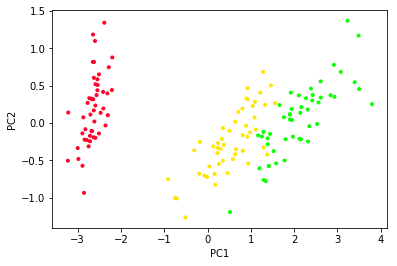

In [8]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

Text(0,0.5,'Sepal width')

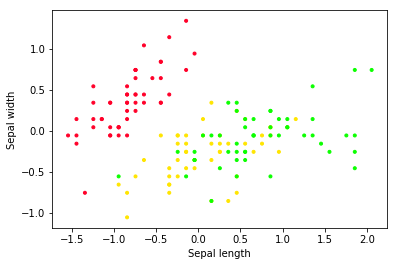

In [9]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(iris_features[:, 0], iris_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('Sepal length')
fig.set_ylabel('Sepal width')

In [10]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Set prior params

In [11]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [12]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Set up model

In [13]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

# Set inits

In [14]:
set_truth = False

In [15]:
if set_truth: 
    # set to the true centroids: 
    centroid_init = np.zeros((dim, k_approx))
    info_init = np.zeros((k_approx, dim, dim))
    for k in range(k_approx): 
        if k < 3: 
            k_indx = np.argwhere(iris_species == k).flatten()
            centroid_k = np.mean(model.y[k_indx, :], axis = 0)

            resid_k = model.y[k_indx, :] - centroid_k

            cov_init = np.dot(resid_k.T, resid_k)

            info_init[k, :, :] = np.linalg.inv(cov_init)
            centroid_init[:, k] = centroid_k
        else: 
            info_init[k, :, :] = np.eye(dim)
    
    model.vb_params['global']['centroids'].set(centroid_init)
    model.vb_params['global']['gamma'].set(info_init)
    
    model.set_optimal_z()
    
    init_global_free_param = model.global_vb_params.get_free()
    
        
    
else: 
    # run k-means init
    n_kmeans_init = 50
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)


# look at initializations

In [16]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

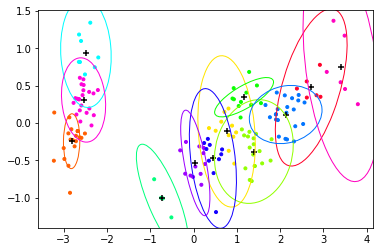

In [17]:
init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

In [18]:
print(np.linalg.norm(model.vb_params['global']['gamma'].get()))

10409.879713358841


In [19]:
# %%R -i init_clusters -i init_centroids -w 4 -h 3 --units in -r 200
#     k_approx <- dim(init_centroids)[2]
#     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
#     pca_centroids_init$cluster <- as.factor(seq(1, k_approx, by = 1))
#     # TODO: plot the centroids too 

#     # add our initial clusterings to the dataframe
#     df_pca$init_clusters <- as.factor(init_clusters)
    
#     # plot
#     ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = init_clusters), size = 0.5) + 
#         theme(legend.position="none") 

# Optimize!

In [20]:
t0 = time.time()
best_param, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model.optimize_full(init_global_free_param,
    init_max_iter=200,
    final_max_iter=500)
t_newton = time.time() - t0

print('done. ')

BGFS
Iter: 0	 RMSE: 5.4171664084976205	 Objective: 4865.172927669948
Iter: 10	 RMSE: 10.663487726019486	 Objective: 3139.840570638689
Iter: 20	 RMSE: 11.53771717801997	 Objective: 2263.04439556202
Iter: 30	 RMSE: 11.030946757199741	 Objective: 640.5224954703313
Iter: 40	 RMSE: 13.031530036778843	 Objective: -31.385806548685906
Iter: 50	 RMSE: 9.900488027471692	 Objective: -224.2522751064795
Iter: 60	 RMSE: 8.88763373361511	 Objective: -287.76872438419895
Iter: 70	 RMSE: 9.168656217270106	 Objective: -308.4353178601797
Iter: 80	 RMSE: 9.204548945488575	 Objective: -313.7268451006005
Iter: 90	 RMSE: 9.148551298798028	 Objective: -317.0939079216308
Iter: 100	 RMSE: 9.168239516972553	 Objective: -319.4522590996009
Iter: 110	 RMSE: 9.146772973250558	 Objective: -320.3085619209535
Iter: 120	 RMSE: 9.120638286869527	 Objective: -321.1835026946261
Iter: 130	 RMSE: 9.14205823177278	 Objective: -321.3427462369771
Iter: 140	 RMSE: 9.097396707735482	 Objective: -322.10306271050166
Iter: 150	 RMSE:

In [21]:
newton_results = deepcopy(model)

In [22]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [23]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

### look at bnp clusters

In [24]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

Text(0,0.5,'PC2')

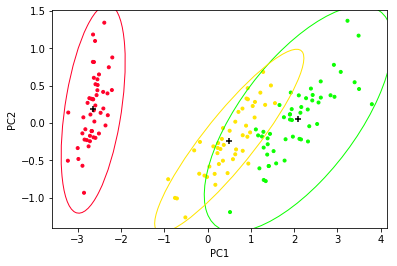

In [25]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
colors1_[0] = colors1[2]
colors1_[1] = colors1[0]
colors1_[2] = colors1[1]

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [26]:
# import json 

# fit_dict = model.get_checkpoint_dictionary(seed=453453)

# json_output_file = '../GMM_clustering/iris_fits/full_data_fits/iris_bnp_full_data_fit.json'
# print('saving fit dict to ', json_output_file)

# with open(json_output_file, 'w') as outfile:
#     json.dump(fit_dict, outfile)


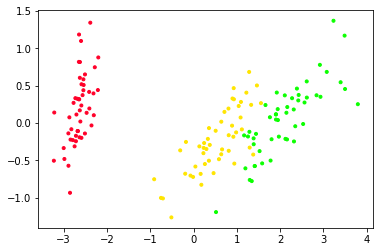

In [27]:
# recall true clustering
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

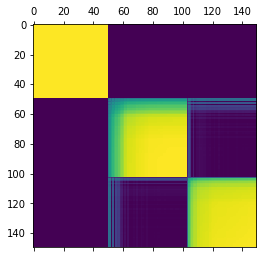

In [28]:
model.set_from_global_free_par(newton_results.global_vb_params.get_free())
e_z = model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z, e_z.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
indx_best = sch.dendrogram(y, no_plot=True)["leaves"]

co_cluster_mat = co_cluster_mat[indx_best][:, indx_best]

plt.matshow(co_cluster_mat)


In [29]:
# %%R -i bnp_clusters -i bnp_centroids -w 4 -h 3 --units in -r 200
# #     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# #     pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# # add our bnp clusterings to the dataframe
# df_pca$bnp_clusters <- as.factor(bnp_clusters)

# # plot
# ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#     theme(legend.position="none") 

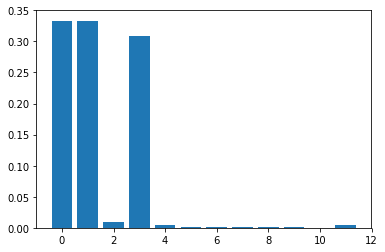

In [30]:
cluster_weights = np.sum(newton_results.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
plt.bar(np.arange(len(cluster_weights)), cluster_weights); 

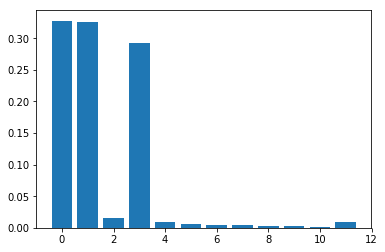

In [31]:
posterior_weights = model.get_e_cluster_probabilities()
plt.bar(np.arange(len(posterior_weights)), posterior_weights); 

(array([  1.,   1.,   0.,   1.,   1.,   2.,   4.,   4.,   6., 130.]),
 array([0.30781304, 0.37703174, 0.44625043, 0.51546913, 0.58468782,
        0.65390652, 0.72312522, 0.79234391, 0.86156261, 0.9307813 ,
        1.        ]),
 <a list of 10 Patch objects>)

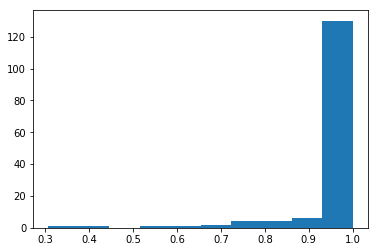

In [32]:
plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))

# Lets look at a few random restarts, see how results chage

In [33]:
n_restarts = 6
init_global_free_param_array = []
global_free_param_array = []

for i in tqdm(range(n_restarts)):
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)
    best_param, kl_hessian, kl_hessian_corrected, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
        model.optimize_full(init_global_free_param,
            init_max_iter=300,
            final_max_iter=500, disp=True)
    
    init_global_free_param_array.append(init_global_free_param)
    global_free_param_array.append(best_param)



  0%|          | 0/6 [00:00<?, ?it/s]

BGFS
Iter: 0	 RMSE: 5.598913912817113	 Objective: 10618.195665790261
Iter: 10	 RMSE: 9.456185668751049	 Objective: 5253.718183063053
Iter: 20	 RMSE: 13.915562659081946	 Objective: 2335.8270959758643
Iter: 30	 RMSE: 15.021620365884457	 Objective: 458.4371177622267
Iter: 40	 RMSE: 12.7992686399922	 Objective: 27.918756361540375
Iter: 50	 RMSE: 12.435725239112308	 Objective: -134.82043200762223
Iter: 60	 RMSE: 11.39336273408802	 Objective: -234.21682774791725
Iter: 70	 RMSE: 10.480671674429031	 Objective: -261.0415672031205
Iter: 80	 RMSE: 10.29838026450205	 Objective: -280.4106459654617
Iter: 90	 RMSE: 10.152486576559479	 Objective: -290.1797436348601
Iter: 100	 RMSE: 9.206619055966081	 Objective: -296.801561788815
Iter: 110	 RMSE: 7.651142449223651	 Objective: -301.9554544719881
Iter: 120	 RMSE: 7.777005408089379	 Objective: -305.622043494943
Iter: 130	 RMSE: 7.808232748307954	 Objective: -308.19626261534046
Iter: 140	 RMSE: 7.740506594879625	 Objective: -309.58626510337416
Iter: 150	 R

 17%|█▋        | 1/6 [00:22<01:52, 22.45s/it]

Iter: 330	 RMSE: 7.6069246099548655	 Objective: -320.19137203102355
         Current function value: -320.191372
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 7.621507591704102e-14, f_diff = 3.410605131648481e-13
BGFS
Iter: 0	 RMSE: 5.501912308288866	 Objective: 10955.844612994571
Iter: 10	 RMSE: 11.589648368301512	 Objective: 5457.945291410239
Iter: 20	 RMSE: 16.203713173834966	 Objective: 3175.9546265727604
Iter: 30	 RMSE: 14.341523099126011	 Objective: 409.1879905656717
Iter: 40	 RMSE: 17.138508030845706	 Objective: 94.13907798565378
Iter: 50	 RMSE: 11.351532224927354	 Objective: -77.89759786289596
Iter: 60	 RMSE: 10.747539162830222	 Objective: -179.09623210599966
Iter: 70	 RMSE: 11.293001957995651	 Objective: -241.97611394561594
Iter: 80	 RMSE: 11.580382557157778	 Objective: -287.6804662164548
Iter: 90	 RMSE: 11.462732928201648	 Objective: -297.8202115390292
Iter: 100	 RMSE: 11.4299444884141

 33%|███▎      | 2/6 [00:42<01:24, 21.22s/it]

         Current function value: -311.902079
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 4.657298852128733e-14, f_diff = 7.389644451905042e-13
BGFS
Iter: 0	 RMSE: 5.652922263084551	 Objective: 10833.71628230006
Iter: 10	 RMSE: 7.3620476984537655	 Objective: 5440.92367030348
Iter: 20	 RMSE: 11.164290167660706	 Objective: 3596.540591515904
Iter: 30	 RMSE: 16.008652820688777	 Objective: 1231.2456217481495
Iter: 40	 RMSE: 12.718222837104715	 Objective: 413.97676246218833
Iter: 50	 RMSE: 11.91309492148278	 Objective: -13.931057545166595
Iter: 60	 RMSE: 11.359058955185317	 Objective: -136.96095003651797
Iter: 70	 RMSE: 10.947385863235533	 Objective: -210.5190347879102
Iter: 80	 RMSE: 10.543762970468665	 Objective: -261.86076252590266
Iter: 90	 RMSE: 10.374086475309886	 Objective: -280.69776232145296
Iter: 100	 RMSE: 10.22723678006399	 Objective: -290.00889567165893
Iter: 110	 RMSE: 10.1090766183539	

 50%|█████     | 3/6 [01:23<01:23, 27.99s/it]

         Current function value: -319.483546
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 2: x_diff = 1.2540170766463157e-06, f_diff = 1.7053025658242404e-13
BGFS
Iter: 0	 RMSE: 6.292717731907797	 Objective: 10836.823474413179
Iter: 10	 RMSE: 11.141232199682689	 Objective: 5470.745333013407
Iter: 20	 RMSE: 12.657588161706467	 Objective: 4320.706316726169
Iter: 30	 RMSE: 17.772525553855147	 Objective: 2288.7656875175535
Iter: 40	 RMSE: 12.634231676478526	 Objective: 0.9785071376886094
Iter: 50	 RMSE: 12.445380936549597	 Objective: -199.13101564232983
Iter: 60	 RMSE: 12.46088393825357	 Objective: -262.6101162252192
Iter: 70	 RMSE: 12.436733561436666	 Objective: -287.0110967366714
Iter: 80	 RMSE: 12.417602435501456	 Objective: -297.92416027125824
Iter: 90	 RMSE: 12.425266000022633	 Objective: -303.21307665155246
Iter: 100	 RMSE: 12.422366963600966	 Objective: -304.20332644017833
Iter: 110	 RMSE: 12.41617729

 67%|██████▋   | 4/6 [01:43<00:51, 25.79s/it]

Optimization terminated successfully.
         Current function value: -319.354499
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 2.843330893198808e-05, f_diff = 3.979039320256561e-12
BGFS
Iter: 0	 RMSE: 5.861557365130375	 Objective: 10856.564505042927
Iter: 10	 RMSE: 8.440659346554376	 Objective: 5738.98142672398
Iter: 20	 RMSE: 11.232572764429165	 Objective: 4693.543219421534
Iter: 30	 RMSE: 14.194590948112337	 Objective: 1451.9249440444219
Iter: 40	 RMSE: 23.836163414601703	 Objective: 427.3389919990493
Iter: 50	 RMSE: 12.667326025525126	 Objective: 7.3246659701102885
Iter: 60	 RMSE: 12.507859010634016	 Objective: -177.98570209520128
Iter: 70	 RMSE: 12.452636696063207	 Objective: -257.4293193521985
Iter: 80	 RMSE: 12.43386387154085	 Objective: -285.4740758405468
Iter: 90	 RMSE: 12.431219880816037	 Objective: -294.3742958943426
Iter: 100	 RMSE: 12.408609648466973	 Objective: -297.68576092473955

 83%|████████▎ | 5/6 [02:29<00:29, 29.98s/it]

         Current function value: -316.271287
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 5.5874142118605974e-14, f_diff = 1.3642420526593924e-12
BGFS
Iter: 0	 RMSE: 5.509730988580523	 Objective: 10640.337681740097
Iter: 10	 RMSE: 9.136962927969137	 Objective: 5439.091465276323
Iter: 20	 RMSE: 12.268163807886003	 Objective: 3458.7548426306857
Iter: 30	 RMSE: 31.15247623064537	 Objective: 629.5609165333007
Iter: 40	 RMSE: 12.999592690561387	 Objective: -2.192313922525983
Iter: 50	 RMSE: 12.4830711348737	 Objective: -175.52852199307742
Iter: 60	 RMSE: 12.454551827088935	 Objective: -240.38334203354958
Iter: 70	 RMSE: 12.460952255778446	 Objective: -281.4247215549905
Iter: 80	 RMSE: 12.449641136854044	 Objective: -291.63791940474283
Iter: 90	 RMSE: 12.425545304839156	 Objective: -295.15195975910854
Iter: 100	 RMSE: 12.394323441412332	 Objective: -297.2857310084152
Iter: 110	 RMSE: 12.3167077370793

100%|██████████| 6/6 [02:58<00:00, 29.71s/it]

         Current function value: -329.464652
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 5.1920382056203085e-14, f_diff = 1.9895196601282805e-12


final objective val, restart 0:  -320.1913720310238
final objective val, restart 1:  -311.9020792167768
final objective val, restart 2:  -319.4835457899008
final objective val, restart 3:  -319.35449922024776
final objective val, restart 4:  -316.2712867806795
final objective val, restart 5:  -329.4646520309209


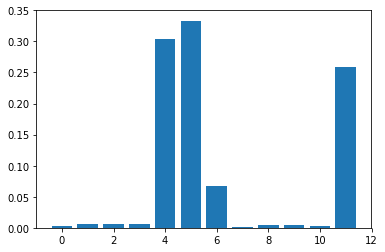

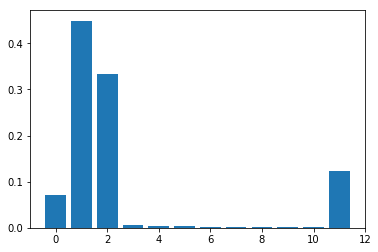

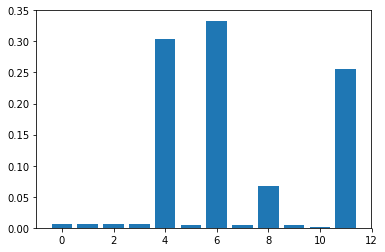

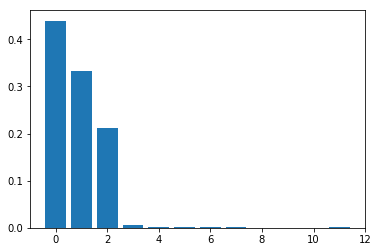

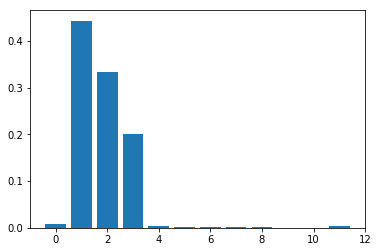

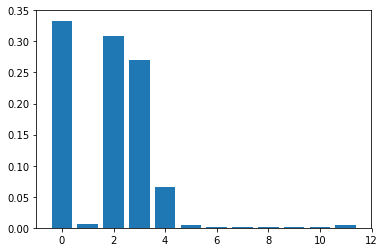

In [34]:
# get cluster assignments
cluster_assignments_array = []
bnp_centroids_pc_array = []
bnp_cluster_covs_pc_array = []

for i in range(n_restarts): 
    model.set_from_global_free_par(global_free_param_array[i])
    bnp_centroids_pc_, bnp_cluster_covs_pc_ = \
        transform_params_to_pc_space(pca_fit, \
                                     model.vb_params['global']['centroids'].get(),\
                                     np.linalg.inv(model.vb_params['global']['gamma'].get()))
        
    bnp_centroids_pc_array.append(bnp_centroids_pc_)
    bnp_cluster_covs_pc_array.append(bnp_cluster_covs_pc_)
    
    cluster_assignments_array.append(np.argmax(model.vb_params['e_z'].get(), axis = 1))
    
    plt.figure()
    cluster_weights = np.sum(model.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
    plt.bar(np.arange(len(cluster_weights)), cluster_weights); 
    
#     plt.figure()
#     plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))
    
    print('final objective val, restart {}: '.format(i), model.set_z_get_kl())

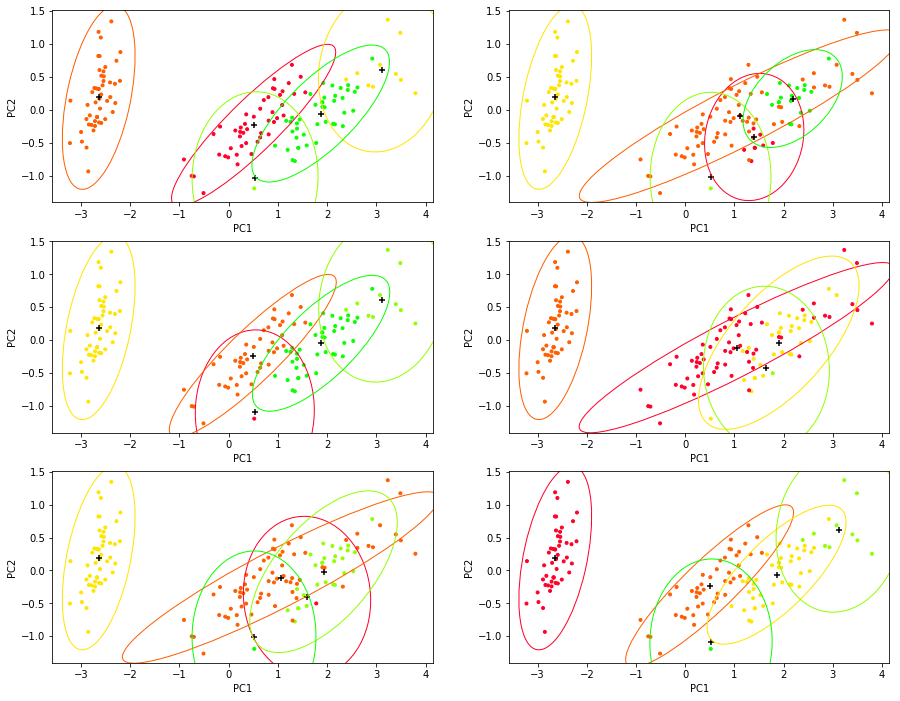

In [35]:
f, axarr = plt.subplots(3, 2, figsize = (15, 12))

for i in range(n_restarts): 
    axarr_indx1 = int(np.floor(i / 2))
    axarr_indx2 = i % 2
    plot_clusters(pc_features[:, 0], pc_features[:, 1], cluster_assignments_array[i], \
                  colors2, axarr[axarr_indx1, axarr_indx2], 
                 centroids = bnp_centroids_pc_array[i][:, np.unique(cluster_assignments_array[i])], \
                 cov = bnp_cluster_covs_pc_array[i][np.unique(cluster_assignments_array[i])])
    axarr[axarr_indx1, axarr_indx2].set_xlabel('PC1')
    axarr[axarr_indx1, axarr_indx2].set_ylabel('PC2')

In [36]:
# %%R
# # an R multiplot function
# multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
#   library(grid)

#   # Make a list from the ... arguments and plotlist
#   plots <- c(list(...), plotlist)

#   numPlots = length(plots)

#   # If layout is NULL, then use 'cols' to determine layout
#   if (is.null(layout)) {
#     # Make the panel
#     # ncol: Number of columns of plots
#     # nrow: Number of rows needed, calculated from # of cols
#     layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
#                     ncol = cols, nrow = ceiling(numPlots/cols))
#   }

#  if (numPlots==1) {
#     print(plots[[1]])

#   } else {
#     # Set up the page
#     grid.newpage()
#     pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

#     # Make each plot, in the correct location
#     for (i in 1:numPlots) {
#       # Get the i,j matrix positions of the regions that contain this subplot
#       matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

#       print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
#                                       layout.pos.col = matchidx$col))
#     }
#   }
# }


In [37]:
# %%R -i cluster_assignments_array -i n_restarts -w 5 -h 8 --units in -r 200
# # pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# # pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# plot_list <- list()
# for(i in 1:n_restarts){
#     # add our bnp clusterings to the dataframe
#     # print(cluster_assignments_array[, i])
#     df_pca$bnp_clusters <- as.factor(cluster_assignments_array[, i])
    
#     plot <- ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#      theme(legend.position="none") 
    
#     plot_list[[i]] <- plot
# }

# # plot_list[[1]]

# multiplot(plotlist = plot_list, cols = 2)

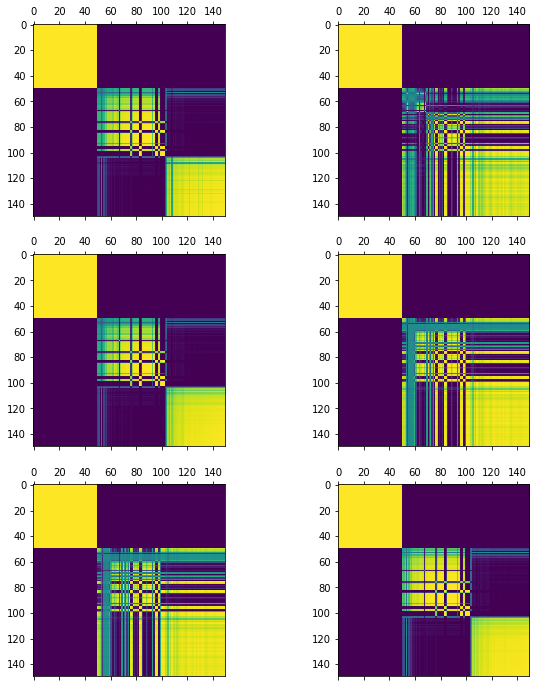

In [38]:
f, axarr = plt.subplots(3, 2, figsize=(10, 12))

for i in range(n_restarts): 
    model.set_from_global_free_par(global_free_param_array[i])
    e_z = model.vb_params['e_z'].get()
    co_cluster_mat = np.dot(e_z, e_z.T)
    
#     if i == 0: 
#         dis = (co_cluster_mat + 1) ** (-1)
#         dis[np.diag_indices_from(dis)] = 0
#         dis = spatial.distance.squareform(dis, checks=False)
#         y = sch.linkage(dis, method='average')
#         indx = sch.dendrogram(y, no_plot=True)["leaves"]
    
    co_cluster_mat = co_cluster_mat[indx_best][:, indx_best]
    
    fig_indx1 = int(np.floor(i / 2))
    fig_indx2 = int(i % 2)
    axarr[fig_indx1, fig_indx2].matshow(co_cluster_mat)
    

# Parametric sensitivity

In [39]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = gmm_utils.LinearSensitivity(model, moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [40]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [41]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))


0.06543275174582902 2452.4197117909416


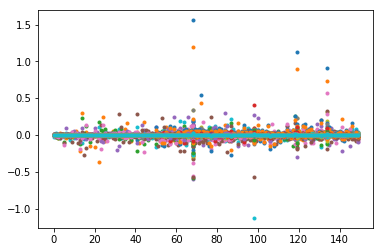

In [42]:
# sensitivity to data
plt.plot(linear_sens.data_sens_mat.T, '.');


In [43]:
# Choose a prior parameter and check the sensitivity
print('prior indices')
print(model.prior_indices)

prior_ind = 0 # this is the alpha, the parameter for the dp prior

epsilon = 0.5


prior indices
prior_params:
	alpha: [0]
	prior_centroid_mean: [1]
	prior_centroid_info: [2]
	prior_gamma_df: [3]
	prior_gamma_inv_scale:
[[ 4.  5.  7. 10.]
 [ 5.  6.  8. 11.]
 [ 7.  8.  9. 12.]
 [10. 11. 12. 13.]]


In [44]:
model_perturbed = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks)

perturb_vec = np.zeros(model_perturbed.prior_params.vector_size())
perturb_vec[prior_ind] = epsilon

model_perturbed.prior_params.set_vector(
    model_perturbed.prior_params.get_vector() + perturb_vec)

pert_opt_free_param = \
    model_perturbed.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


BGFS
Iter: 0	 RMSE: 9.044112569275718	 Objective: -320.6083771361439
Iter: 10	 RMSE: 9.025917540948711	 Objective: -320.6573737635921
Iter: 20	 RMSE: 9.023508847999732	 Objective: -320.6516382430348
Iter: 30	 RMSE: 9.02093172779682	 Objective: -320.7006011322003
Iter: 40	 RMSE: 9.018974741705874	 Objective: -320.69490382613964
Iter: 50	 RMSE: 9.020711046068348	 Objective: -320.7170605521971
Iter: 60	 RMSE: 9.02181537107261	 Objective: -320.7182315577784
Iter: 70	 RMSE: 9.021748520684065	 Objective: -320.71827977865973
Iter: 80	 RMSE: 9.021738486787442	 Objective: -320.71828119646995
Optimization terminated successfully.
         Current function value: -320.718281
         Iterations: 71
         Function evaluations: 90
         Gradient evaluations: 90
Conditioned Newton:
i =  0
Iter: 90	 RMSE: 9.021736089122179	 Objective: -320.7182812291848
         Current function value: -320.718281
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         

Text(0.5,1,'global free parameters')

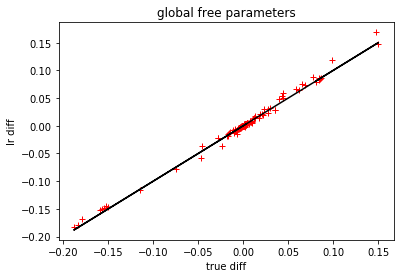

In [45]:
free_perturb_vec = model_perturbed.prior_params.get_free() - model.prior_params.get_free()
lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)

diff_vec = pert_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')
plt.title('global free parameters')


In [46]:
print(linear_sens.moment_model.moment_params['v_sticks'])

v_sticks:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Text(0,0.5,'lr diff')

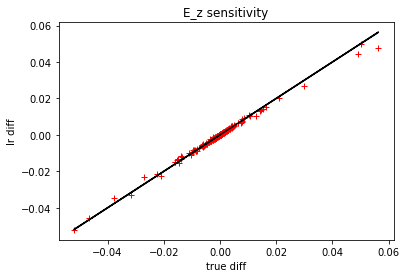

In [47]:
## check e_z sensitivity

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
# cluster_weights_orig = np.mean(e_z_orig, axis = 0)
cluster_weights_orig = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))

linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
# cluster_weights_pert = np.mean(e_z_pert, axis = 0)
cluster_weights_pert = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
# cluster_weights_lr = np.mean(e_z_lr, axis = 0)
cluster_weights_lr = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))

diff_vec = (e_z_pert - e_z_orig).flatten()
lr_diff_vec = (e_z_lr - e_z_orig).flatten()

plt.title('E_z sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


Text(0,0.5,'lr diff')

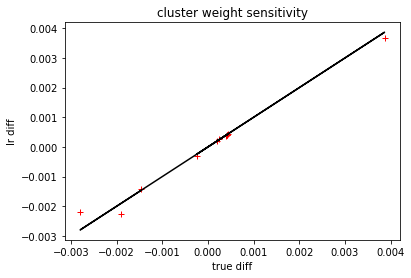

In [48]:
# check sensitivity of cluster weights

diff_vec = (np.sort(cluster_weights_pert) - np.sort(cluster_weights_orig)).flatten()
lr_diff_vec = (np.sort(cluster_weights_lr) - np.sort(cluster_weights_orig)).flatten()

plt.title('cluster weight sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


Text(0,0.5,'lr diff')

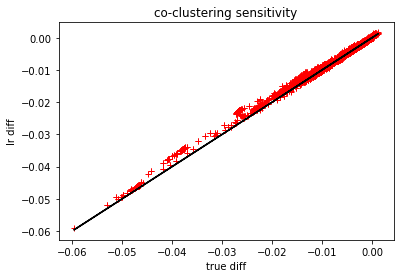

In [49]:
# check co-clustering sensitivity
coclustering_orig = np.matmul(e_z_orig, e_z_orig.T)
coclustering_pert = np.matmul(e_z_pert, e_z_pert.T)
coclustering_lr = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (coclustering_pert - coclustering_orig).flatten()
lr_diff_vec = (coclustering_lr - coclustering_orig).flatten()


plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


Text(0,0.5,'lr diff')

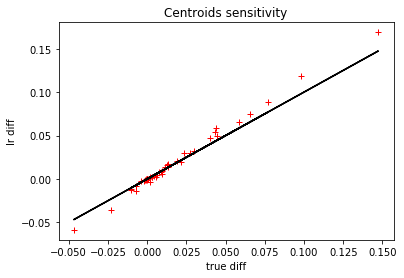

In [50]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_beta_lr = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec = (e_beta_pert - e_beta_orig).flatten()
lr_diff_vec = (e_beta_lr - e_beta_orig).flatten()

plt.title('Centroids sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [83]:
def get_e_number_clusters_from_free_par(model, global_free_params, samples = 10000): 
    model.global_vb_params.set_free(global_free_params)
    return modeling_lib.get_e_number_clusters_from_logit_sticks_diffble(model.vb_params, samples = samples)

In [84]:
get_e_number_clusters_from_free_par(model, newton_results.global_vb_params.get_free())

6.471847379646483

In [85]:
get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)

7.360053330986013

In [86]:
get_e_number_clusters_from_free_par(model, pert_opt_free_param)

6.6364804952110426

# check how well the linear approximation holds over a range of epsilons

In [87]:
epsilons = [-3, -2, -1.5, -1, -0.5, 0.5, 1, 2, 4, 6]

In [88]:
len(epsilons)

10

In [89]:
pert_opt_free_param_list = []
pert_prior_free_params_list = []

# re-optimize for each epsilon
for i in range(len(epsilons)): 
    print('optimizing when epsilon = {}'.format(epsilons[i]))
    
    perturb_vec = np.zeros(model_perturbed.prior_params.vector_size())
    perturb_vec[prior_ind] = epsilons[i]

    model_perturbed.prior_params.set_vector(
        newton_results.prior_params.get_vector() + perturb_vec)
    # print(model_perturbed.prior_params.get_vector())
    
    pert_prior_free_params_list.append(model_perturbed.prior_params.get_free())
    
    pert_opt_free_param_list.append(
        model_perturbed.optimize_full(best_param, init_max_iter=100, final_max_iter=500, disp = False)[0])


optimizing when epsilon = -3
optimizing when epsilon = -2
optimizing when epsilon = -1.5
optimizing when epsilon = -1
optimizing when epsilon = -0.5
optimizing when epsilon = 0.5
optimizing when epsilon = 1
optimizing when epsilon = 2
optimizing when epsilon = 4
optimizing when epsilon = 6


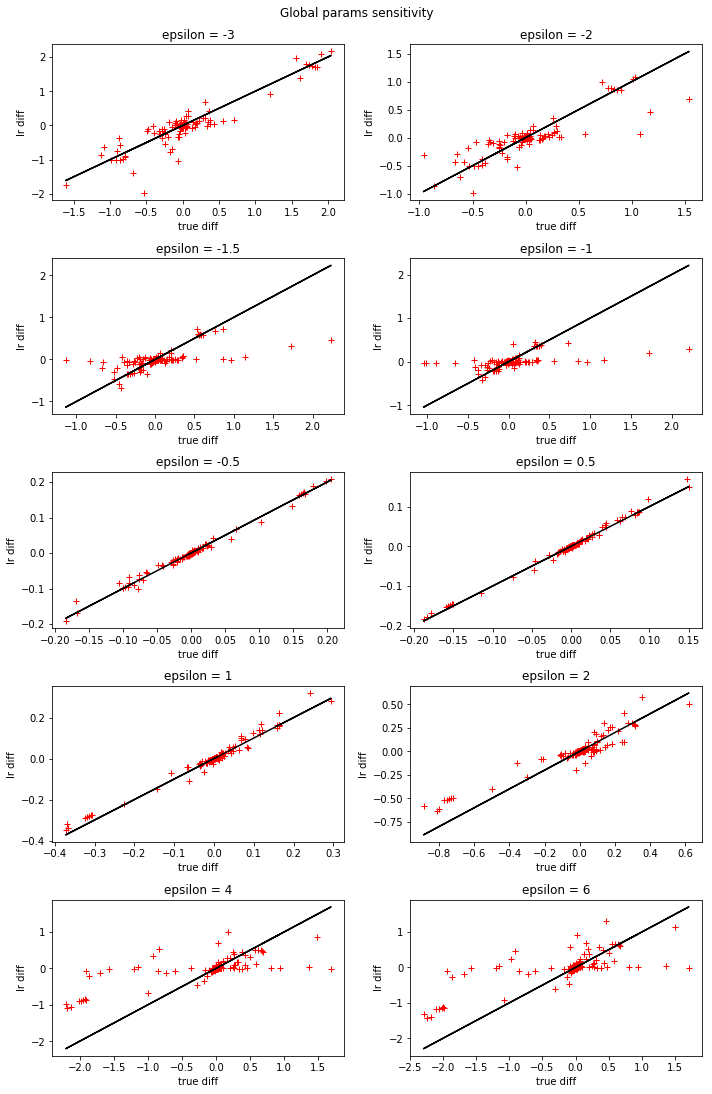

In [58]:
# check global params

linear_sens.moment_model.set_moments_from_free_par(best_param)


f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Global params sensitivity')

for i in range(len(epsilons)): 
    
    # diff in prior free params
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    
    # get linear response global free params
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)
    
    # diff in original global free params
    diff_vec = (pert_opt_free_param_list[i] - best_param).flatten()
    lr_diff_vec = (lr_free_param_diff_vec).flatten()
    
    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    
f.tight_layout()
blah.set_y(1.01)

# f.savefig('../writing/Bryan_writing/parametric_sens_figures/beta_sens_range.png', bbox_inches='tight')


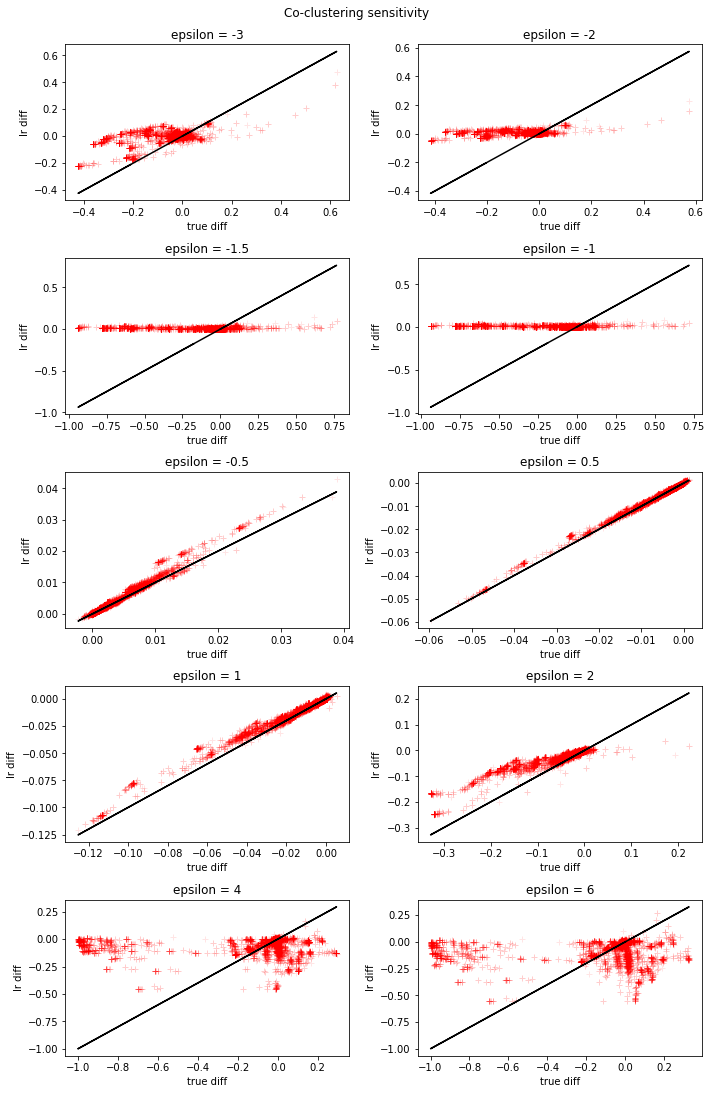

In [59]:
# check e_z's 

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_og = np.matmul(e_z_orig, e_z_orig.T)

f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Co-clustering sensitivity')

for i in range(len(epsilons)): 
    
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)

    linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param_list[i])
    e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
    co_cluster_pert = np.matmul(e_z_pert, e_z_pert.T)
    
    
    linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
    e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
    co_cluster_lr = np.matmul(e_z_lr, e_z_lr.T)
    
#     diff_vec = (e_z_pert - e_z_orig).flatten()
#     lr_diff_vec = (e_z_lr - e_z_orig).flatten()

    diff_vec = (co_cluster_pert - co_cluster_og).flatten()
    lr_diff_vec = (co_cluster_lr - co_cluster_og).flatten()

    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+', alpha = 0.1)
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    # axarr[indx1, indx2].set_xlim([-0.06, 0.06])
    
f.tight_layout()
blah.set_y(1.01)


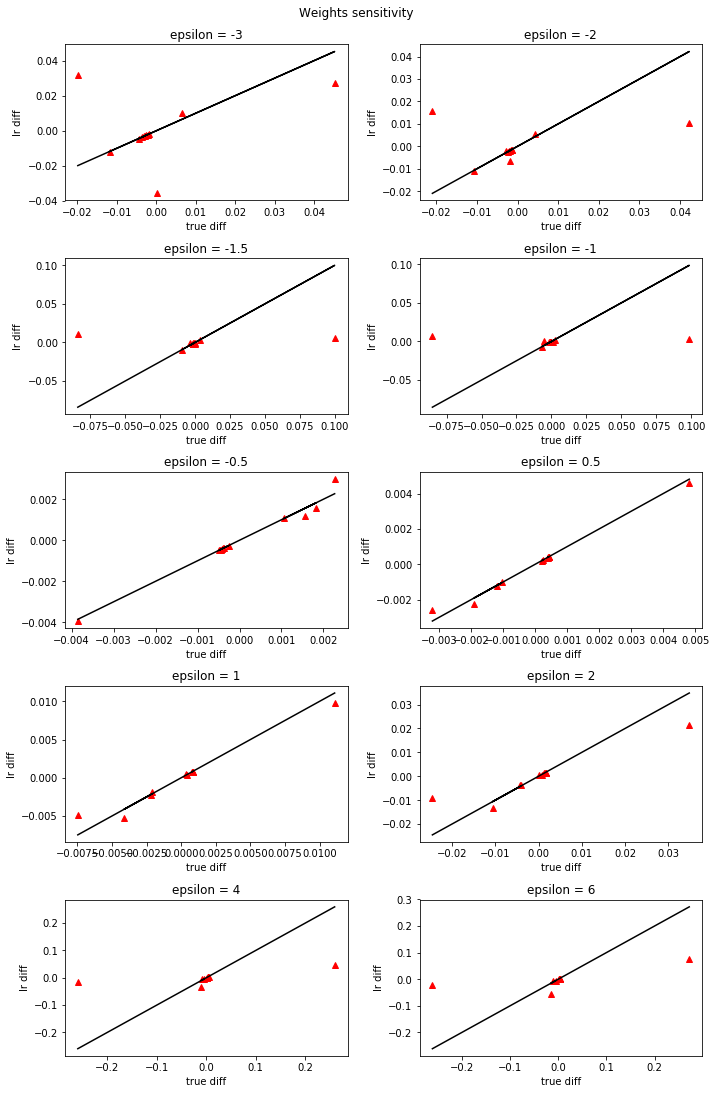

In [60]:
# check weights's 

linear_sens.moment_model.set_moments_from_free_par(best_param)
weights_og = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))

f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Weights sensitivity')

for i in range(len(epsilons)): 
    
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)

    linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param_list[i])
    weights_pert = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))
    
    linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
    weights_lr = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))
    
#     diff_vec = (e_z_pert - e_z_orig).flatten()
#     lr_diff_vec = (e_z_lr - e_z_orig).flatten()

    diff_vec = (weights_pert - weights_og).flatten()
    lr_diff_vec = (weights_lr - weights_og).flatten()

    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r^')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    # axarr[indx1, indx2].set_xlim([-0.06, 0.06])
    
f.tight_layout()
blah.set_y(1.01)


Text(0,0.5,'expected number of clusters')

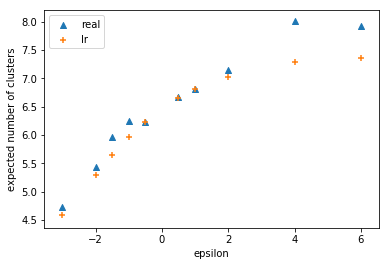

In [61]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

e_n_clusters = np.zeros(len(epsilons))
e_n_clusters_lr = np.zeros(len(epsilons))
for i in range(len(epsilons)): 
    e_n_clusters[i] = get_e_number_clusters_from_free_par(model, pert_opt_free_param_list[i])
    
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)
    
    e_n_clusters_lr[i] = get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)


plt.scatter(epsilons, e_n_clusters, marker = '^')
plt.scatter(epsilons, e_n_clusters_lr, marker = '+')
plt.legend(('real', 'lr'))
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')

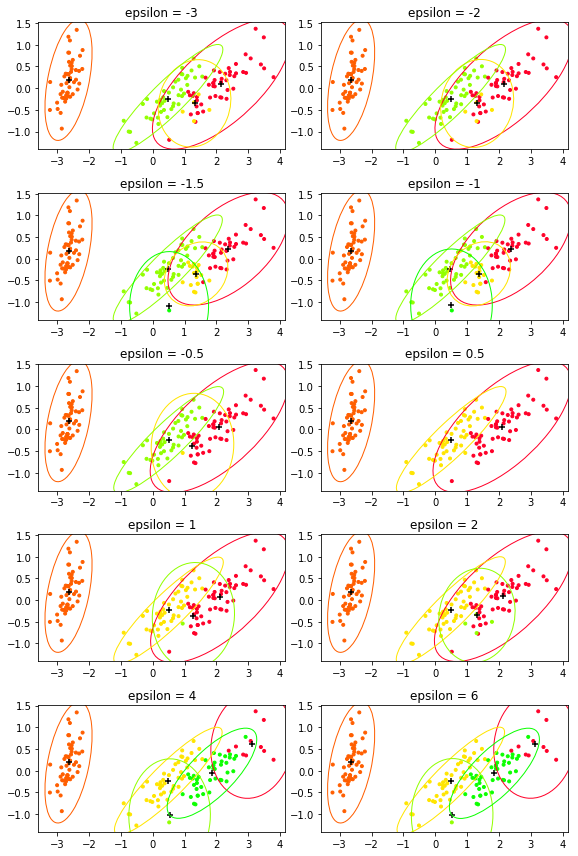

In [62]:
f, axarr = plt.subplots(int(len(epsilons)/2), 2, figsize = (8, 12))

for i in range(len(epsilons)): 
    
    linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param_list[i])
    e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
    cluster_assignments = np.argmax(e_z_pert, axis = 1)
    
    centroids = linear_sens.moment_model.moment_params['centroids'].get()
    covs = np.linalg.inv(linear_sens.moment_model.model.vb_params['global']['gamma'].get())

    pc_centroids, pc_covs = transform_params_to_pc_space(pca_fit, centroids, covs)
    
    axarr_indx1 = int(np.floor(i / 2))
    axarr_indx2 = i % 2

    plot_clusters(pc_features[:, 0], pc_features[:, 1], cluster_assignments, \
                  colors2, axarr[axarr_indx1, axarr_indx2], 
                 centroids = pc_centroids[:, np.unique(cluster_assignments)], \
                 cov = pc_covs[np.unique(cluster_assignments)])
    axarr[axarr_indx1, axarr_indx2].set_title('epsilon = {}'.format(epsilons[i]))
    
f.tight_layout()


In [63]:
model.set_from_global_free_par(pert_opt_free_param_list[-1])
e_z = model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z, e_z.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
indx = sch.dendrogram(y, no_plot=True)["leaves"]


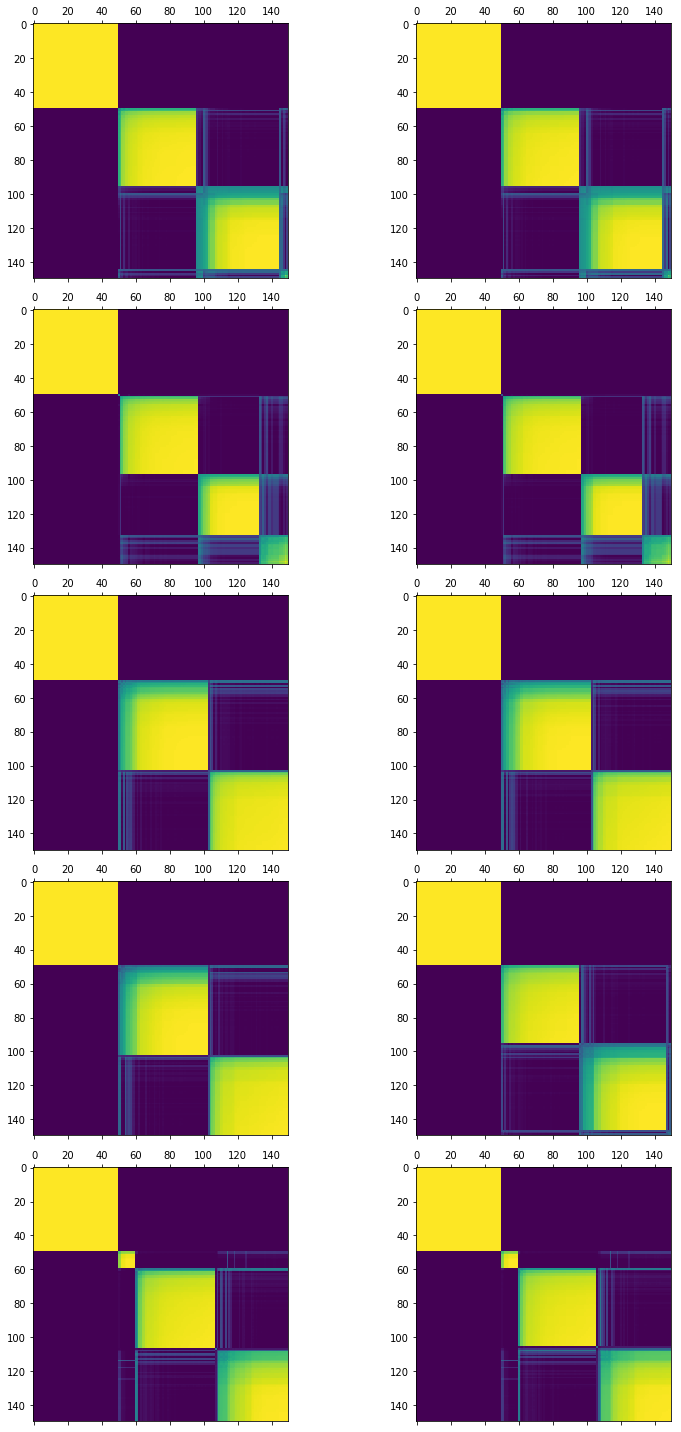

In [64]:
f, axarr = plt.subplots(5, 2, figsize=(12, 20))

for i in range(len(epsilons)): 
    model.set_from_global_free_par(pert_opt_free_param_list[i])
    e_z = model.vb_params['e_z'].get()
    co_cluster_mat = np.dot(e_z, e_z.T)
    
    dis = (co_cluster_mat + 1) ** (-1)
    dis[np.diag_indices_from(dis)] = 0
    dis = spatial.distance.squareform(dis, checks=False)
    y = sch.linkage(dis, method='average')
    indx = sch.dendrogram(y, no_plot=True)["leaves"]
    
    co_cluster_mat = co_cluster_mat[indx][:, indx]
    
    fig_indx1 = int(np.floor(i / 2))
    fig_indx2 = int(i % 2)
    axarr[fig_indx1, fig_indx2].matshow(co_cluster_mat)

f.tight_layout()


### what if we perturb and start from a different initialization 

In [65]:
model_perturbed2 = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks)

perturb_vec = np.zeros(model_perturbed.prior_params.vector_size())
perturb_vec[prior_ind] = 0.5

model_perturbed2.prior_params.set_vector(
    model.prior_params.get_vector() + perturb_vec)

print(model_perturbed2.prior_params.get_vector())
print(model_perturbed2.prior_indices)


print('k-means initialization ...')
t0 = time.time()
init_global_free_param = model_perturbed2.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)
t_kmeans = time.time() - t0

pert_opt_free_param2 = \
    model_perturbed2.optimize_full(init_global_free_param, init_max_iter=100, final_max_iter=500)[0]


[4.5  0.   0.1  8.   0.62 0.   0.62 0.   0.   0.62 0.   0.   0.   0.62]
prior_params:
	alpha: [0]
	prior_centroid_mean: [1]
	prior_centroid_info: [2]
	prior_gamma_df: [3]
	prior_gamma_inv_scale:
[[ 4.  5.  7. 10.]
 [ 5.  6.  8. 11.]
 [ 7.  8.  9. 12.]
 [10. 11. 12. 13.]]
k-means initialization ...
BGFS
Iter: 0	 RMSE: 5.49049304180544	 Objective: 10840.045720992715
Iter: 10	 RMSE: 9.667307374091665	 Objective: 5852.53333241314
Iter: 20	 RMSE: 17.75855587604923	 Objective: 3808.1885441721574
Iter: 30	 RMSE: 18.387904931975765	 Objective: 1019.2226413224971
Iter: 40	 RMSE: 13.825858311635454	 Objective: 316.85228179514553
Iter: 50	 RMSE: 13.793814137360693	 Objective: 38.96118298165166
Iter: 60	 RMSE: 10.268831699999973	 Objective: -133.17568319670502
Iter: 70	 RMSE: 10.78921202545651	 Objective: -235.23943506710168
Iter: 80	 RMSE: 10.488744892307546	 Objective: -285.39196763309815
Iter: 90	 RMSE: 10.439920635449806	 Objective: -297.5875078591321
Iter: 100	 RMSE: 10.152916439556236	 Objec

In [66]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_og = np.matmul(e_z_orig, e_z_orig.T)

# results when starting from original optimum
linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_pert = np.matmul(e_z_pert, e_z_pert.T)

# results when starting from random new optimum
linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param2)
e_z_pert2 = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_pert2 = np.matmul(e_z_pert2, e_z_pert2.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_lr = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_cluster_pert2 - co_cluster_og).flatten()
lr_diff_vec = (co_cluster_lr - co_cluster_og).flatten()


Text(0,0.5,'lr diff')

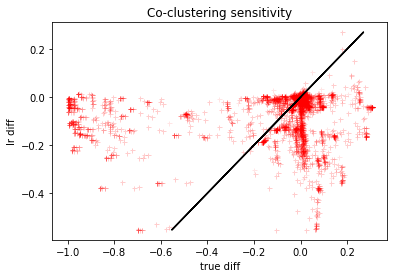

In [67]:
#indx = np.abs(diff_vec) < 0.008
plt.title('Co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+', markersize = 5, alpha = 0.1)
plt.plot(lr_diff_vec, lr_diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


Text(0,0.5,'lr diff')

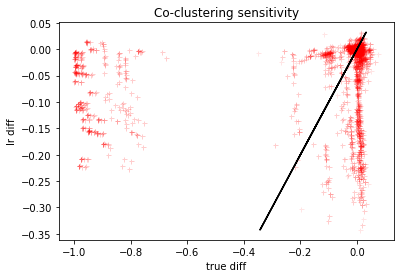

In [68]:
# Lets look at co-clustering again, but subsetting to 
# those with confident cluster belonings

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()

sure_indx = np.argwhere(np.max(e_z_orig, axis = 1) > 0.9).flatten()

co_cluster_sure_og = np.matmul(e_z_orig[sure_indx, :], e_z_orig[sure_indx, :].T)
co_cluster_sure_pert2 = np.matmul(e_z_pert2[sure_indx, :], e_z_pert2[sure_indx, :].T)
co_cluster_sure_lr = np.matmul(e_z_lr[sure_indx, :], e_z_lr[sure_indx, :].T)

diff_vec = (co_cluster_sure_pert2 - co_cluster_sure_og).flatten()
lr_diff_vec = (co_cluster_sure_lr - co_cluster_sure_og).flatten()

plt.title('Co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+', markersize = 5, alpha = 0.1)
plt.plot(lr_diff_vec, lr_diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


# Functional Sensitivty

In [69]:
best_param = newton_results.global_vb_params.get_free()

In [70]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)


# lets look at weights instead 
def get_kth_weight_from_free_param(model, free_par, k): 
    model.set_from_global_free_par(free_par)
    e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)
    
    return modeling_lib.get_kth_weight_from_sticks(np.array([e_sticks]), k)

g_eta = np.zeros((k_approx, model.global_vb_params.free_size()))
for k in range(k_approx): 
    get_g_eta = autograd.jacobian(get_kth_weight_from_free_param, argnum = 1)
    g_eta[k, :] = get_g_eta(model, best_param, k)

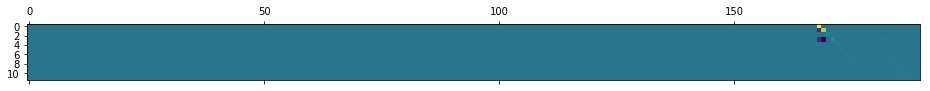

In [71]:
plt.matshow(g_eta)

In [72]:
model.set_from_global_free_par(best_param)
e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)

for i in range(k_approx): 
    assert np.abs(get_kth_weight_from_free_param(model, best_param, i) - \
                        modeling_lib.get_mixture_weights(e_sticks)[i]) < 1e-12

In [73]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_sticks = np.zeros((k_approx, len(theta)))
for k in range(k_approx - 1): 
    total_influence_sticks += np.dot(g_eta, linear_sens.influence_function(theta, k))


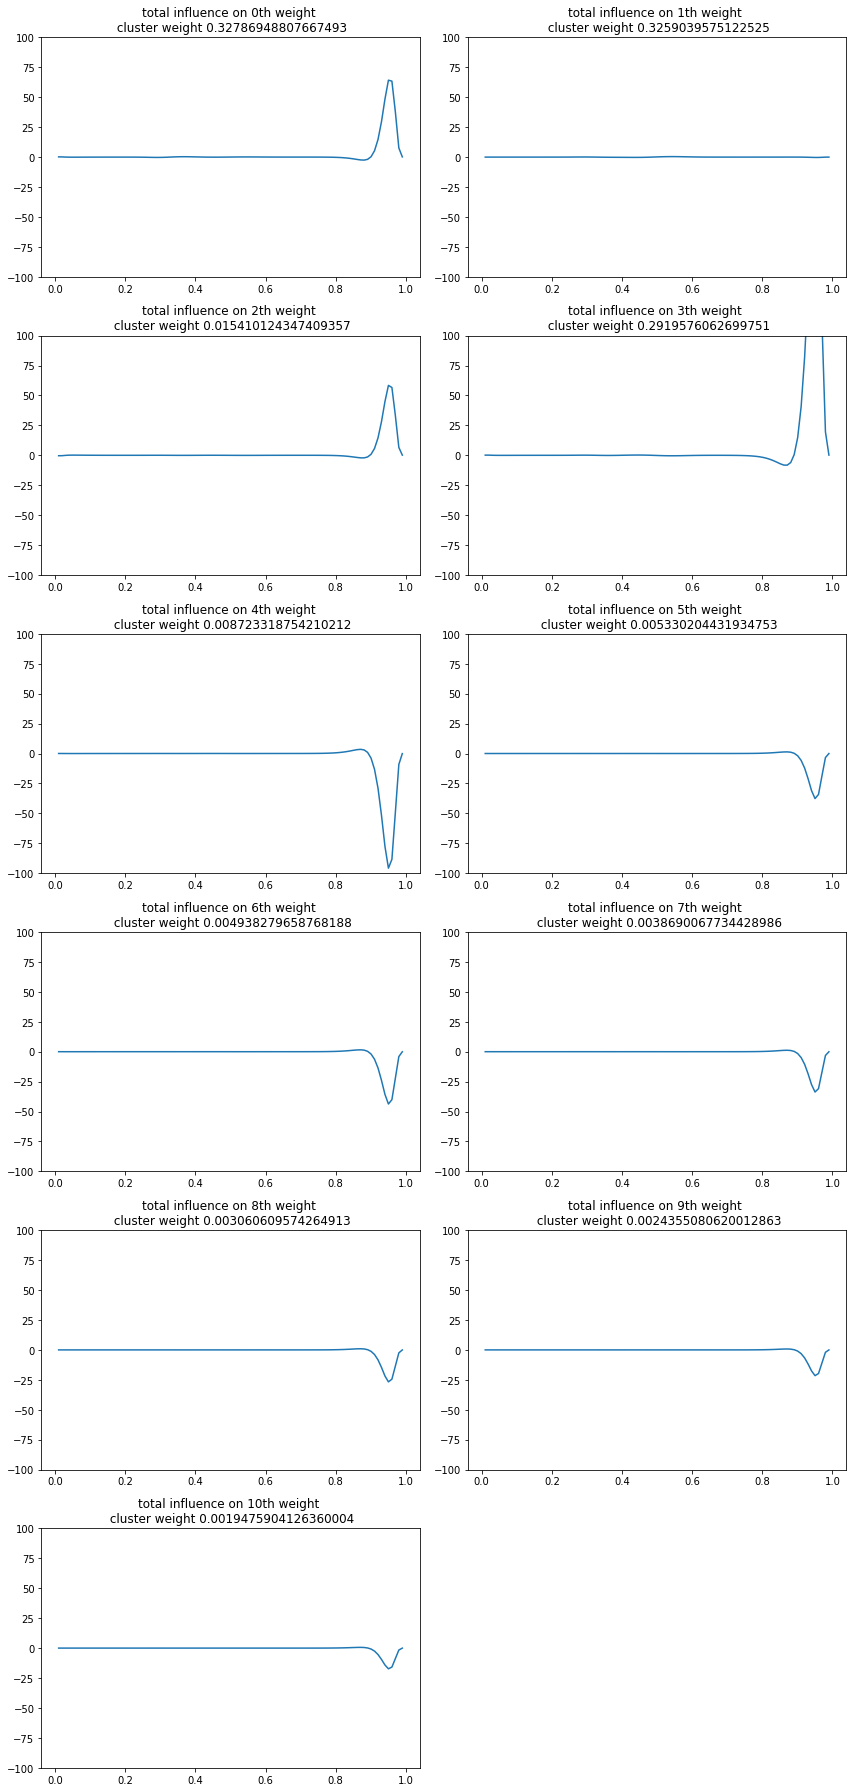

In [74]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, total_influence_sticks[k, :])
    axarr[indx1, indx2].set_ylim([-100.0, 100.0])
    
    weights = linear_sens.model.get_e_cluster_probabilities()
    axarr[indx1, indx2].set_title('total influence on {}th weight \n cluster weight {}'.format(k, weights[k]))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])

f.tight_layout()


In [75]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [76]:
get_g_eta_nclust = autograd.jacobian(get_e_number_clusters_from_free_par, argnum = 1)
g_eta_nclust = get_g_eta_nclust(model, best_param)

In [77]:
theta = np.linspace(0.01, 0.99, 100)
influence_n_clust = np.zeros((k_approx, len(theta)))

for k in range(k_approx - 1): 
    influence_n_clust[k, :] += np.dot(np.array([g_eta_nclust]), \
                                           linear_sens.influence_function(theta, k)).flatten()


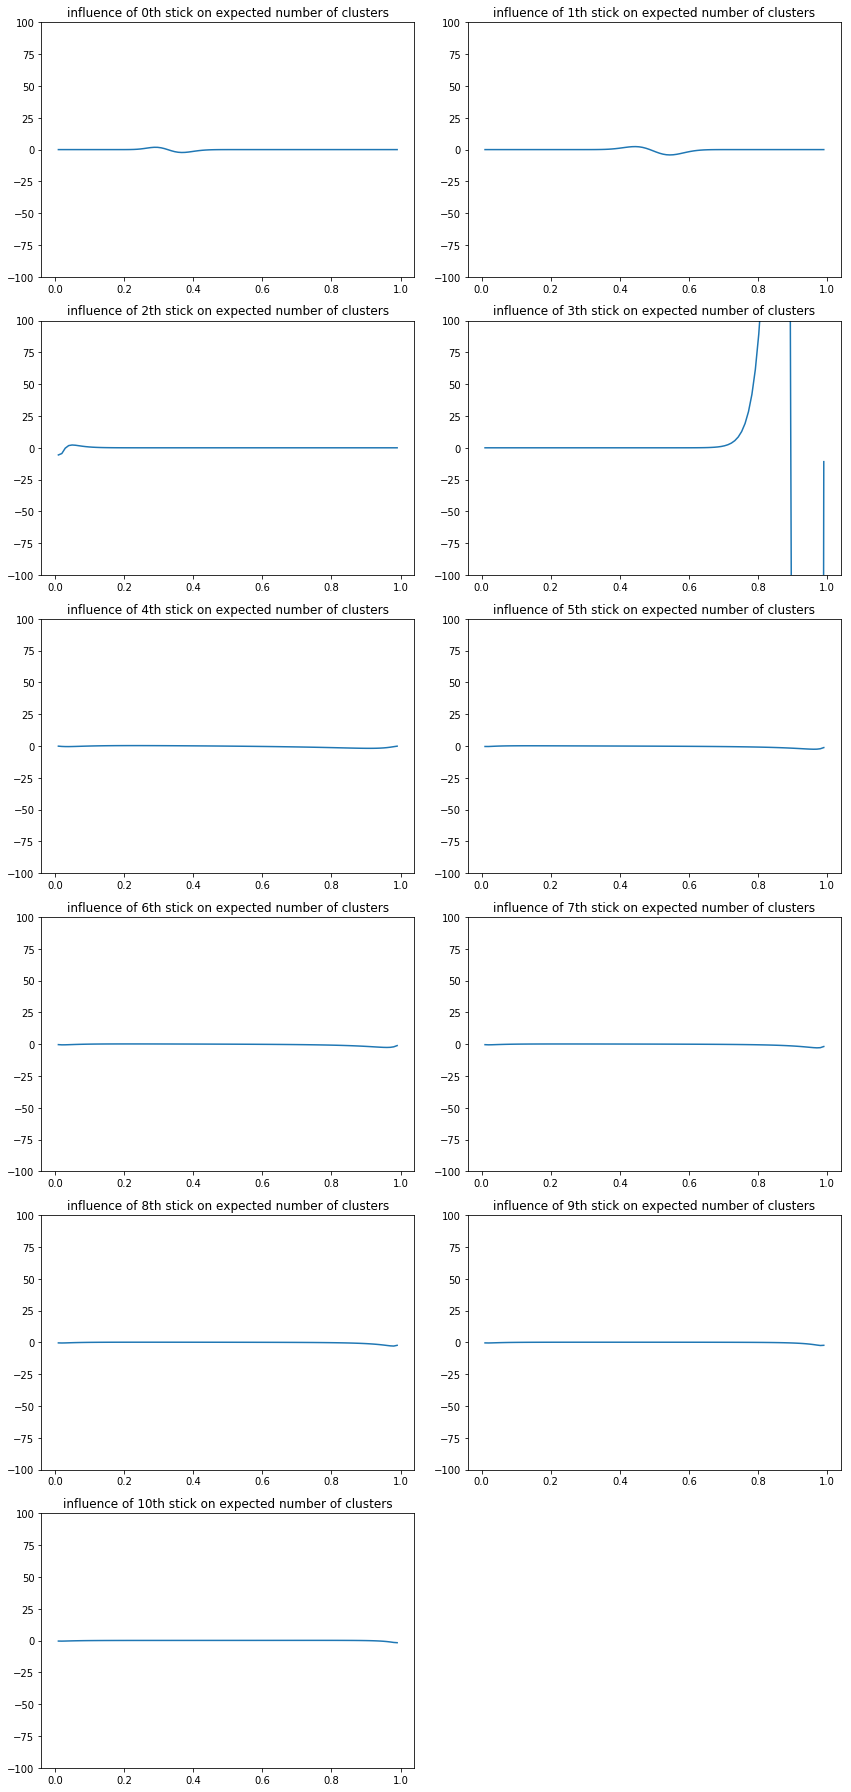

In [78]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, influence_n_clust[k, :])
    axarr[indx1, indx2].set_ylim([-100.0, 100.0])
    
    weights = linear_sens.model.get_e_cluster_probabilities()
    axarr[indx1, indx2].set_title('influence of {}th stick on expected number of clusters'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])

f.tight_layout()


In [79]:
total_influence_n_clust = np.sum(influence_n_clust, axis = 0)

Text(0.5,1,'total influence on expected number of clusters')

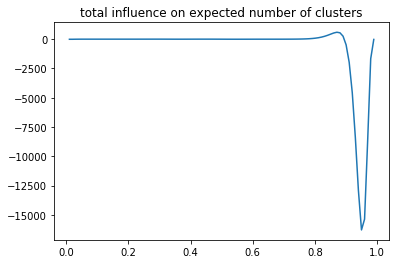

In [80]:
plt.plot(theta, total_influence_n_clust)
plt.title('total influence on expected number of clusters')

(-100, 100)

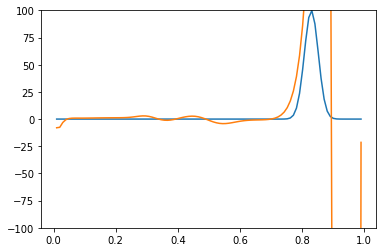

In [81]:
# lets choose a perturbation 
epsilon = 0.001

# u = lambda x : np.exp(-(x - 0.97)**2 / 0.01)
u = lambda x : np.exp(-(x - 0.83)**2 / 0.001)

plt.plot(theta, u(theta) * 100)
plt.plot(theta, total_influence_n_clust)
plt.ylim((-100, 100))

In [82]:
# get functional sensitivity
fun_sens_mat = linear_sens.get_functional_sensitivity(lambda x : u(x) * epsilon)

TypeError: get_functional_sensitivity() missing 1 required positional argument: 'k'

In [ ]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [ ]:
# Perturb and re-optimize
model_u_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : u(x) * epsilon)

pert_u_opt_free_param = \
    model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


In [ ]:
lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1))

diff_vec = pert_u_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_og = np.matmul(e_z_orig, e_z_orig.T)

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_pert = np.matmul(e_z_pert, e_z_pert.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_lrvb = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_clustering_pert - co_clustering_og).flatten()
lr_diff_vec = (co_clustering_lrvb - co_clustering_og).flatten()

plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', alpha = 0.01)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
v_sticks_orig = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
v_sticks_pert = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
v_sticks_lr = linear_sens.moment_model.moment_params['v_sticks'].get()

diff_vec = (v_sticks_pert - v_sticks_orig).flatten()
lr_diff_vec = (v_sticks_lr - v_sticks_orig).flatten()

plt.title('v_sticks sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', markersize = 10)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
beta_og = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
beta_lrvb = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec1 = (beta_pert - beta_og).flatten()
lr_diff_vec1 = (beta_lrvb - beta_og).flatten()

plt.title('Centroid sensitivity')
plt.plot(diff_vec1, lr_diff_vec1, 'r^', markersize = 10)
plt.plot(diff_vec1, diff_vec1, 'k') 

plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
get_e_number_clusters_from_free_par(model, best_param)

In [ ]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, pert_u_opt_free_param))

In [ ]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))